The following dataset contains 1m rows of http response data from a web crawler, with the following schema:

hostnameHash - this is a hash of the hostname of the http request url.

pageGuid - this is a unique ID assigned to the http response received

parentPageGuid - the unique ID of the parent page of this request (more explanation on this below).

httpResponseCode - the http response code received

responseBodyMD5 - the md5 hash of the response body received

responseBodySize - the size, in bytes, of the response body

contentType - the contents of the content type header


In this web crawler, every http response is assigned a unique ID.  If a http response loads dependent requests (e.g., if we make a request to http://www.google.com, the response may include an additional request/response from https://www.google.com/images/nav_logo242.png) then those dependent requests will be assigned a parent page guid that matches the guid of the calling page.  If the parentPageGuid field is null, that means that the corresponding response came from a direct request (i.e., not loaded from some other page).  If the hostnameHash field is null, that means that we were unable to parse the url for some unknown reason.

Suppose you want to understand more about these hosts and their dependent requests.  What can you derive from this data?  Some ideas:

* what does the distribution of dependent requests across hosts look like?  What other basic statistics might be interesting to describe this data?
* can you classify hosts into reasonable "types" based on these features?  Conceivably, www.google.com will look different from www.nytimes.com, but perhaps www.google.com and www.bing.com are similar?

* are there interesting correlations between dependent requests?

* any other interesting question you might want to answer...

 

Please time-box your work to no more than 3 hours.  If you don't have time to generate results, please describe what you've done so far and the approach you would use if you were to invest more time into the problem.

 

Dataset link: https://drive.google.com/open?id=1l_fzmf1ncpm45EIwk4KZojPtT3uGscCj

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv('./data/rb_md5s.txt',delimiter='\t')

In [16]:
df.columns=('hostnameHash','pageGuid','parentPageGuid','httpResponseCode','responseBodyMD5','responseBodySize','contentType')

In [17]:
df.to_pickle('./pickle/df1.pkl')

In [18]:
df=pd.read_pickle('./pickle/df1.pkl')

In [3]:
df.head()

,hostnameHash,pageGuid,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
0,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,e998b51a-e117-4e28-8bc2-f3aa52b6cca9,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
1,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,b80e939c-ec86-4ba0-a21b-a05f47d11f69,302,07b4511278d33e0a152458bc56121059,128.0,text/html
2,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,14d39101-c2ac-46bc-bde9-fbb5822fc41c,200,d681413ffee243c992957f487973ad36,13381.0,text/javascript
3,131a460e5e56b32eb51e09395cb62074,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,d9ad296b-5ea3-4964-bd15-e9e5fe52b873,200,687707a77e06dbaecaaa688f8485bad1,561539.0,application/javascript
4,131a460e5e56b32eb51e09395cb62074,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,b188df1f-03e5-4b86-961e-0283120c1edd,200,376728432654e63a857795e2d2738d47,188011.0,text/css


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 7 columns):
hostnameHash        986330 non-null object
pageGuid            979613 non-null object
parentPageGuid      999999 non-null object
httpResponseCode    999999 non-null int64
responseBodyMD5     998726 non-null object
responseBodySize    814720 non-null float64
contentType         952771 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 53.4+ MB


In [14]:
df[['hostnameHash','parentPageGuid']].groupby(['hostnameHash','parentPageGuid']).count()

Empty DataFrame
Columns: []
Index: [(000704a3e488015d32cc64a86dc32310, 2a24aa6f-f281-498c-b34e-78a174e441ef), (000758a353fa674f968ab5d837170129, 03ef9533-5019-46fc-b158-352cac804b67), (000758a353fa674f968ab5d837170129, 03f2d54d-7a96-4178-a0e3-8f54908d8a94), (000758a353fa674f968ab5d837170129, 175c1232-e080-4be6-9544-cec697bd28ed), (000758a353fa674f968ab5d837170129, 18754e3c-0ff7-42a6-bffc-f39fd4991dab), (000758a353fa674f968ab5d837170129, 31678c13-62d0-404b-8c07-18fba375dcbb), (000758a353fa674f968ab5d837170129, 3b9cf7f6-f6b0-4972-a67c-706c74986bfd), (000758a353fa674f968ab5d837170129, 44ae513d-16da-416f-89b1-94709270fadb), (000758a353fa674f968ab5d837170129, 686ee1d3-0eef-4358-b71e-cc9e300aaf09), (000758a353fa674f968ab5d837170129, 92c91896-61b7-4aab-9bb5-5869a39cb93c), (000758a353fa674f968ab5d837170129, 974f888d-cb43-47dc-b94f-658c1246b5c0), (000758a353fa674f968ab5d837170129, ce57696a-2fcd-4761-8594-f9f989b2d2d9), (000758a353fa674f968ab5d837170129, e6888321-f81c-4fe4-a92a-73bc2209adbe), (000758a353fa674f968ab5d837170129, f8a977df-33e6-42b8-aa23-3d53728b24ed), (000758a353fa674f968ab5d837170129, fc7cfb12-f729-4e22-8774-0c03c8ddd374), (000758a353fa674f968ab5d837170129, feb9ab90-88d0-450c-9629-dfe3d1a725ef), (0007f9134e2994a9622699faa03fb446, 1283b292-e493-45f2-8883-3d6914014b27), (0007f9134e2994a9622699faa03fb446, 157b34fa-aab6-4939-ac33-10d4cab91f86), (0007f9134e2994a9622699faa03fb446, b3ea426c-9c77-4b6f-a896-78905f0cbac4), (0007f9134e2994a9622699faa03fb446, fa00e59a-e0b1-4f1a-8539-652564381be3), (000e7c78f3f74a9a932d54887cc6bb4f, 99562b76-5280-4a03-93b2-dce984b31aa3), (000e7c78f3f74a9a932d54887cc6bb4f, aacef6a2-6f7e-4ec6-ae04-4392bb708e76), (00152d5fbe4125b51f6f9f46b862ecd3, 2a09d81c-42f0-4972-84a4-cacb0be2a9f7), (00152d5fbe4125b51f6f9f46b862ecd3, 30d278f5-d256-45ec-9542-4061297a25b5), (00152d5fbe4125b51f6f9f46b862ecd3, 49661479-9761-42ce-a1e9-22c28f9a2af1), (0018c5469e810975769bd2470233868f, 2e71674c-17fd-4152-a7a1-4fefe9fb3faa), (0018c5469e810975769bd2470233868f, bc90d247-d12b-4f9d-8628-6ba119905426), (001d74bb3f28aaed078c549b35420d03, 34dedce4-7eee-4559-b69d-6f92ef853689), (001d74bb3f28aaed078c549b35420d03, 75cf2220-b867-4dc2-9291-4ac969719600), (001d74bb3f28aaed078c549b35420d03, 8248240d-120f-4ff5-aeaf-13e797a0f7cc), (001d74bb3f28aaed078c549b35420d03, a281c882-9516-4538-aac1-4b2eda2d6162), (001d74bb3f28aaed078c549b35420d03, e2c888a8-5571-4168-b7bd-5d4c8161141d), (001d74bb3f28aaed078c549b35420d03, e95f6aea-190a-464f-875b-0b681e9014e8), (001dcc1adf7693e8639d1d8132b77a90, 42295d01-8b9a-4656-ba9c-caaff8a4190f), (001dcc1adf7693e8639d1d8132b77a90, 8a984937-a6f4-4a67-bc8a-6fc35423caa6), (0021e2d1a666100a9ca1d9d99b98a068, 00003fbf-bfa9-4b8a-b8e0-028cbf0a3077), (0021e2d1a666100a9ca1d9d99b98a068, 012e3181-dc86-4bfe-889b-4a632e245d29), (0021e2d1a666100a9ca1d9d99b98a068, 01612b67-0786-487c-8377-bb4d957ff3f2), (0021e2d1a666100a9ca1d9d99b98a068, 04c02b95-6f13-4581-822f-12d1d8acd30c), (0021e2d1a666100a9ca1d9d99b98a068, 0fd1f8e1-8c13-42ef-a7d4-358fe82ac5eb), (0021e2d1a666100a9ca1d9d99b98a068, 0fdaedbb-4225-4e76-ac08-7d11d68e8258), (0021e2d1a666100a9ca1d9d99b98a068, 157f3c17-9347-4611-b2cb-f873bfbd664f), (0021e2d1a666100a9ca1d9d99b98a068, 17742137-0299-4a85-bb1b-ed1f55a1e81a), (0021e2d1a666100a9ca1d9d99b98a068, 179e49fd-9104-4012-8524-12689dde59b2), (0021e2d1a666100a9ca1d9d99b98a068, 236a2d81-1770-4927-a21c-2050023e618b), (0021e2d1a666100a9ca1d9d99b98a068, 23dcc09a-d3c5-4502-8981-d53f308b9276), (0021e2d1a666100a9ca1d9d99b98a068, 26a8c130-1179-4923-b7cd-33d8b6eb517d), (0021e2d1a666100a9ca1d9d99b98a068, 29acccf2-3a56-4bb3-8e2a-81766b3c5c56), (0021e2d1a666100a9ca1d9d99b98a068, 2bfb0262-b6bc-447f-aa55-242146b53847), (0021e2d1a666100a9ca1d9d99b98a068, 2d730557-8dc9-4811-9511-e30889446105), (0021e2d1a666100a9ca1d9d99b98a068, 2e5d9beb-32a4-4cb2-a3ad-2016dac367b6), (0021e2d1a666100a9ca1d9d99b98a068, 36975fa4-ca53-4311-acd6-915a73099bba), (0021e2d1a666100a9ca1d9d99b98a068, 3743073f-0818-4f22-9c1c-bb452e3100b1), (0021e2d1a666100a9ca1d9d99b98a068, 3774bd9

In [12]:
df.hostnameHash.value_counts()

cd1a781f134611f5e4cc24f76562bb7d    46514
131a460e5e56b32eb51e09395cb62074    36243
6ecf85dc29265a5041fc6ba07dd5b2ab    15798
c948dd7a61887edf9074a9f8c6461e34    12893
5804529ee4cfd3f4b630fa1e79e8637c    11271
014d64ec8e2e48a9ea5aa54062bc62c9    10541
0a137b375cc3881a70e186ce2172c8d1     9986
c333f8dafc080266b345002a8a5a5fb5     9576
576b67be8c1de540d053ad568a27af45     9469
59746a0206e4d6dbffaa21c420e4427f     8848
c4240f370111de1ec5203760b2159a3e     8450
3ebc7eff723a1d6549ea96e9d3779b0b     7931
d2153a21c926417514a224f8abca00f1     7347
e845cbdc3785b1a67978cbc5a146a168     7058
6b1f4aeeb2f1c8a68c0e46aec93d550e     6458
d5c5c85e129eb37139f8528b5c71ec3f     5700
f1b57ef2cf3ce2c546da65051aa66a7e     5549
50fbb858c32b045b323f64625c7499a3     5386
3ac992bd8a8bfcdd4b09a10c26e6b220     5320
ee94a17becbadc4e46be55df406de9cf     4988
f8d732cf85e612ab1c5ba0f2c09f0c9f     4929
0a3458ec82a581a4d4f0a68ba1d826c6     4925
caa49edfaf4759aa51e5c0d70e2ca8a8     4609
d1becdd25e5d5290f6d007a07090adea  

In [4]:
hostnamecounts = df.hostnameHash.value_counts()

In [5]:
sum(hostnamecounts.values==1)

4611

In [ ]:
hostnamecounts=hostnamecounts[hostnamecounts > 1000]

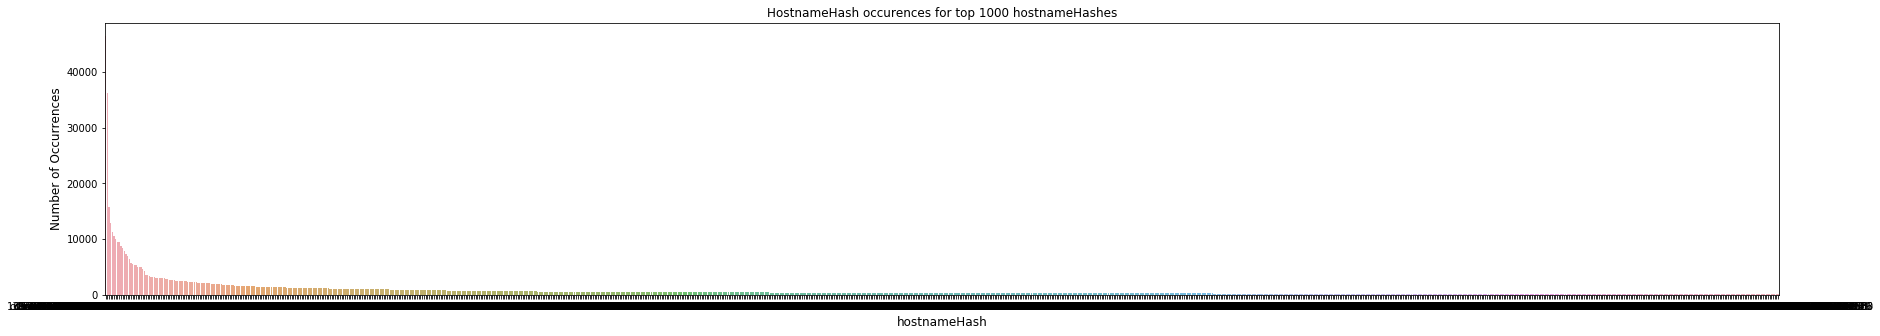

In [11]:
hash_count  = hostnamecounts
hash_count = city_count[:1000,]
plt.figure(figsize=(30,5))
sns.barplot(hash_count.index, hash_count.values, alpha=0.8)
plt.title('HostnameHash occurences for top 1000 hostnameHashes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('hostnameHash', fontsize=12)
plt.show()

In [8]:
len(df.hostnameHash.value_counts())

15572

In [9]:
df[df['parentPageGuid']=='e998b51a-e117-4e28-8bc2-f3aa52b6cca9']

,hostnameHash,pageGuid,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
0,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,e998b51a-e117-4e28-8bc2-f3aa52b6cca9,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN


In [10]:
df[['hostnameHash','pageGuid','parentPageGuid']].groupby(['hostnameHash']).agg('count')

,pageGuid,parentPageGuid
hostnameHash,,
000704a3e488015d32cc64a86dc32310,0,1
000758a353fa674f968ab5d837170129,13,15
0007f9134e2994a9622699faa03fb446,4,4
000e7c78f3f74a9a932d54887cc6bb4f,2,2
00152d5fbe4125b51f6f9f46b862ecd3,2,3
0018c5469e810975769bd2470233868f,2,2
001d74bb3f28aaed078c549b35420d03,6,6
001dcc1adf7693e8639d1d8132b77a90,2,2
0021e2d1a666100a9ca1d9d99b98a068,79,80


In [59]:
df[df.hhostnameHash=='000758a353fa674f968ab5d837170129']

,hhostnameHash,pageGuid,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
391441,000758a353fa674f968ab5d837170129,NaN,44ae513d-16da-416f-89b1-94709270fadb,200,5eb26bfaea9f28942683e95de226b3d6,483932.0,text/html
391444,000758a353fa674f968ab5d837170129,44ae513d-16da-416f-89b1-94709270fadb,ce57696a-2fcd-4761-8594-f9f989b2d2d9,200,af9345404a1bb88f929ee5a5c88a5b55,30587.0,application/javascript
391471,000758a353fa674f968ab5d837170129,44ae513d-16da-416f-89b1-94709270fadb,3b9cf7f6-f6b0-4972-a67c-706c74986bfd,200,63fb34cac4c1f32053d238b5bb1310c0,4729.0,text/css
391597,000758a353fa674f968ab5d837170129,44ae513d-16da-416f-89b1-94709270fadb,18754e3c-0ff7-42a6-bffc-f39fd4991dab,200,d751713988987e9331980363e24189ce,2.0,application/json
391645,000758a353fa674f968ab5d837170129,44ae513d-16da-416f-89b1-94709270fadb,03ef9533-5019-46fc-b158-352cac804b67,200,5dcb9aa3e06bd1587248a0ee0852c421,666.0,text/css
391646,000758a353fa674f968ab5d837170129,44ae513d-16da-416f-89b1-94709270fadb,92c91896-61b7-4aab-9bb5-5869a39cb93c,200,a33efd2e84e6d9fd5ab4863fd1b1ce7f,636.0,image/png
391656,000758a353fa674f968ab5d837170129,44ae513d-16da-416f-89b1-94709270fadb,31678c13-62d0-404b-8c07-18fba375dcbb,200,9d0e7d5b5b1b0061338a54f4471c4218,3599.0,NaN
391660,000758a353fa674f968ab5d837170129,44ae513d-16da-416f-89b1-94709270fadb,974f888d-cb43-47dc-b94f-658c1246b5c0,200,966d29c342affae5e22cc9baaaf1f204,2795.0,image/png
391745,000758a353fa674f968ab5d837170129,44ae513d-16da-416f-89b1-94709270fadb,f8a977df-33e6-42b8-aa23-3d53728b24ed,200,d41d8cd98f00b204e9800998ecf8427e,NaN,text/html
597823,000758a353fa674f968ab5d837170129,NaN,03f2d54d-7a96-4178-a0e3-8f54908d8a94,200,8fd4c2a1ad05a619e6463ae838d7585a,494420.0,text/html


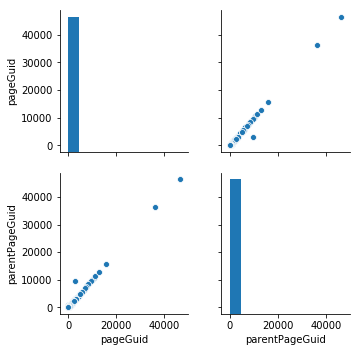

In [62]:
sns.pairplot(pageGuid_dist_df)

In [76]:
df.groupby('hhostnameHash').nunique()

,hhostnameHash,pageGuid,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
hhostnameHash,,,,,,,
000704a3e488015d32cc64a86dc32310,1,0,1,1,1,0,1
000758a353fa674f968ab5d837170129,1,2,15,1,12,11,5
0007f9134e2994a9622699faa03fb446,1,2,4,1,1,1,1
000e7c78f3f74a9a932d54887cc6bb4f,1,2,2,1,1,1,1
00152d5fbe4125b51f6f9f46b862ecd3,1,1,3,1,3,1,1
0018c5469e810975769bd2470233868f,1,1,2,1,1,1,1
001d74bb3f28aaed078c549b35420d03,1,6,6,2,6,3,1
001dcc1adf7693e8639d1d8132b77a90,1,2,2,1,1,1,1
0021e2d1a666100a9ca1d9d99b98a068,1,2,80,3,80,80,7


In [79]:
df[df['hhostnameHash']=='003eb7d4255dad4f0c5d7f3f01f2b2ab'].groupby('pageGuid').agg('count')

,hhostnameHash,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
pageGuid,,,,,,
45c7fe34-bb17-464e-844c-b5c5425fb43a,178,178,178,178,178,178
665f8c77-9c52-4ddd-8c1c-df801a448114,1,1,1,1,1,1


In [88]:
df[df['hhostnameHash'].isnull()]['httpResponseCode'].value_counts()

200    13652
461       17
Name: httpResponseCode, dtype: int64

In [87]:
df['httpResponseCode'].value_counts()

200    857110
302     55733
404     31185
204     16120
470     13824
301      6429
403      4348
400      2758
503      2585
474      1678
429      1563
307      1331
472      1324
0        1273
500       933
303       478
502       332
473       213
410       141
401       122
201        93
471        62
460        53
407        50
202        42
504        40
308        30
405        18
461        17
431        16
414        11
406        10
426        10
505         9
409         8
206         4
520         4
999         4
416         4
462         4
203         4
456         3
445         2
523         2
479         2
508         2
451         2
440         2
422         2
413         2
408         2
719         1
448         1
418         1
415         1
412         1
Name: httpResponseCode, dtype: int64